In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")


In [24]:
#Importing the csv file that contains the data and display first 5 entries
df_raw = pd.read_csv('../DATA-COLLECTION/grosses.csv')
df_raw.head()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0
1,1985-06-09,1,3915937.0,A Chorus Line,Sam S. Shubert Theatre,222584.0,NaN,27.25,NaN,8167,1472,0.6935,8,0
2,1985-06-09,1,3915937.0,Aren't We All?,Brooks Atkinson Theatre,249272.0,NaN,33.75,NaN,7386,1088,0.8486,8,0
3,1985-06-09,1,3915937.0,Arms and the Man,Circle in the Square Theatre,95688.0,NaN,20.87,NaN,4586,682,0.8405,8,0
4,1985-06-09,1,3915937.0,As Is,Lyceum Theatre,61059.0,NaN,20.78,NaN,2938,684,0.5369,8,0


In [3]:
sum(df_raw[df_raw['week_ending'] == "1985-06-09"]["weekly_gross"])

3915937.0

In [4]:
# Getting 3 years data for training and 1 year data for testing

#train year
train_start_date = '2013-06-02 '
train_end_date = '2018-05-27'

#test year
test_start_date = '2018-06-03 '
test_end_date = '2019-05-26'

# Select DataFrame rows between two dates
mask_train = (df_raw['week_ending'] >= train_start_date) & (df_raw['week_ending'] <= train_end_date)
df_train = df_raw.loc[mask_train]
print(df_train)

mask_test = (df_raw['week_ending'] >= test_start_date) & (df_raw['week_ending'] <= test_end_date)
df_test = df_raw.loc[mask_test]
print(df_test)

      week_ending  week_number  weekly_gross_overall  \
36625  2013-06-09            2           23361634.00   
36626  2013-06-09            2           23361634.00   
36627  2013-06-09            2           23361634.00   
36628  2013-06-09            2           23361634.00   
36629  2013-06-09            2           23361634.00   
...           ...          ...                   ...   
44530  2018-05-27           53           39431767.13   
44531  2018-05-27           53           39431767.13   
44532  2018-05-27           53           39431767.13   
44533  2018-05-27           53           39431767.13   
44534  2018-05-27           53           39431767.13   

                                             show                    theatre  \
36625                                         Ann    Vivian Beaumont Theater   
36626                                       Annie             Palace Theatre   
36627                                     Chicago         Ambassador Theatre   
36628  

In [5]:
#converting to panda datetime format
df_train['week_ending'] = pd.to_datetime(df_train['week_ending'])

df_test['week_ending'] = pd.to_datetime(df_test['week_ending'])


In [6]:
df_train.head()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
36625,2013-06-09,2,23361634.0,Ann,Vivian Beaumont Theater,227618.0,1059400.0,57.00,175.0,3993,1113,0.4485,8,0
36626,2013-06-09,2,23361634.0,Annie,Palace Theatre,892876.0,1398648.0,80.57,250.0,11082,1708,0.8110,8,0
36627,2013-06-09,2,23361634.0,Chicago,Ambassador Theatre,551149.0,1013268.0,79.66,186.0,6919,1080,0.8008,8,0
36628,2013-06-09,2,23361634.0,Cinderella,Broadway Theatre,888246.0,1613840.0,88.48,297.0,10039,1751,0.7167,8,0
36629,2013-06-09,2,23361634.0,I'll Eat You Last: A Chat With Sue Mengers,Booth Theatre,791577.0,686165.0,145.89,298.0,5426,777,0.9976,7,0


In [7]:
df_train["theatre"].unique()

array(['Vivian Beaumont Theater', 'Palace Theatre', 'Ambassador Theatre',
       'Broadway Theatre', 'Booth Theatre', 'August Wilson Theatre',
       'Al Hirschfeld Theatre', 'Broadhurst Theatre',
       'Ethel Barrymore Theatre', 'Sam S. Shubert Theatre',
       'Lunt-Fontanne Theatre', 'Nederlander Theatre', 'Imperial Theatre',
       'Bernard B. Jacobs Theatre', 'Music Box Theatre',
       'Helen Hayes Theatre', 'Foxwoods Theatre',
       'Samuel J. Friedman Theatre', "Eugene O'Neill Theatre",
       'Minskoff Theatre', 'Lyceum Theatre', 'Majestic Theatre',
       'Stephen Sondheim Theatre', 'John Golden Theatre',
       'Gershwin Theatre', 'Longacre Theatre', 'Walter Kerr Theatre',
       'St. James Theatre', 'Circle in the Square Theatre',
       'Richard Rodgers Theatre', 'Neil Simon Theatre',
       'American Airlines Theatre', 'Brooks Atkinson Theatre',
       'Belasco Theatre', 'Cort Theatre', 'Marquis Theatre',
       'Gerald Schoenfeld Theatre', 'Winter Garden Theatre',
    

In [8]:
#Entries for each theatre in the dataset
lengths = df_train.groupby('theatre').size()
lengths.sort_values(ascending=False)

theatre
Al Hirschfeld Theatre           259
Minskoff Theatre                259
Ambassador Theatre              259
Gershwin Theatre                259
Eugene O'Neill Theatre          259
Majestic Theatre                259
Stephen Sondheim Theatre        254
Sam S. Shubert Theatre          249
August Wilson Theatre           233
Broadhurst Theatre              229
New Amsterdam Theatre           227
Bernard B. Jacobs Theatre       219
Richard Rodgers Theatre         219
Lunt-Fontanne Theatre           215
Music Box Theatre               208
Brooks Atkinson Theatre         205
Imperial Theatre                201
Broadway Theatre                200
Walter Kerr Theatre             200
Lyceum Theatre                  200
Ethel Barrymore Theatre         198
Circle in the Square Theatre    191
American Airlines Theatre       183
Samuel J. Friedman Theatre      181
Gerald Schoenfeld Theatre       180
Palace Theatre                  177
Longacre Theatre                176
Winter Garden Theatr

In [9]:
# Number of weeks withing this timeframe
diff = df_train['week_ending'].max() - df_train['week_ending'].min()
weeks = diff.days // 7 +1

print("Number of weeks between",df_train['week_ending'].min(), "and", df_train['week_ending'].max(), " = ",  weeks)

Number of weeks between 2013-06-09 00:00:00 and 2018-05-27 00:00:00  =  260


In [10]:
#Checking for a particular popular theatre (Gershwin Theatre)

df_gt = df_train[df_train['theatre'] == 'Gershwin Theatre']

df_gt_test = df_test[df_test['theatre'] == 'Gershwin Theatre']

In [11]:
df_gt

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
36650,2013-06-09,2,23361634.00,Wicked,Gershwin Theatre,1770507.0,1681127.0,135.83,300.0,13035,1809,0.9007,8,0
36676,2013-06-16,3,24770173.00,Wicked,Gershwin Theatre,1849045.0,1681127.0,138.63,300.0,13338,1809,0.9216,8,0
36701,2013-06-23,4,24116853.00,Wicked,Gershwin Theatre,2041391.0,1891268.0,135.25,300.0,15093,1809,0.9270,9,0
36726,2013-06-30,5,24997387.00,Wicked,Gershwin Theatre,1985154.0,1681127.0,142.47,300.0,13934,1809,0.9628,8,0
36749,2013-07-07,6,22845378.00,Wicked,Gershwin Theatre,1893488.0,1681127.0,134.38,300.0,14090,1809,0.9736,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44392,2018-04-29,49,35335326.58,Wicked,Gershwin Theatre,1651308.0,1779845.0,115.88,240.0,14250,1807,0.9857,8,0
44428,2018-05-06,50,36994026.79,Wicked,Gershwin Theatre,1493289.0,1779845.0,114.31,240.0,13063,1807,0.9036,8,0
44464,2018-05-13,51,38621280.34,Wicked,Gershwin Theatre,1541991.0,1779845.0,115.31,240.0,13372,1807,0.9250,8,0
44499,2018-05-20,52,38813251.10,Wicked,Gershwin Theatre,1749587.0,1779845.0,116.93,240.0,14963,1926,0.9711,8,0


In [12]:
#Keeping only the weekly_gross column

df_gt_new = df_gt[['week_ending','weekly_gross']]
df_gt_new.set_index(['week_ending'], inplace = True)

df_gt_test = df_gt_test[['week_ending','weekly_gross']]
df_gt_test.set_index(['week_ending'], inplace = True)


In [13]:
df_gt_new[df_gt_new.index =="2015-12-27"]

,weekly_gross
week_ending,


In [14]:
# Create a reference range of dates
reference_range = pd.date_range(start=df_gt_new.index.min(), end=df_gt_new.index.max(), freq='W-SUN')

# Find missing weeks
missing_weeks = reference_range[~reference_range.isin(df_gt_new.index)]
print(missing_weeks)

DatetimeIndex(['2015-12-27'], dtype='datetime64[ns]', freq='W-SUN')


In [15]:
# Create a reference range of dates
reference_range = pd.date_range(start=df_gt_test.index.min(), end=df_gt_test.index.max(), freq='W-SUN')

# Find missing weeks
missing_weeks = reference_range[~reference_range.isin(df_gt_test.index)]
print(missing_weeks)

DatetimeIndex([], dtype='datetime64[ns]', freq='W-SUN')


In [16]:
#Using backward fill to replacw the missing data
df_gt_new = df_gt_new.resample('W-SUN').bfill()

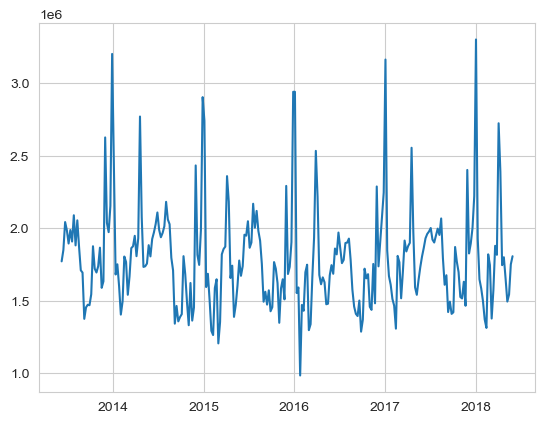

In [17]:
plt.plot(df_gt_new.index ,df_gt_new['weekly_gross'])

### AR MODEL

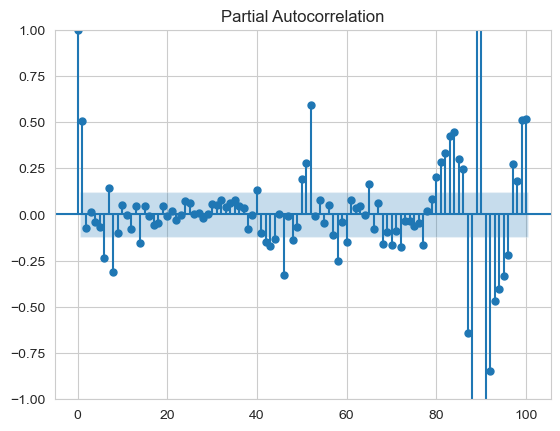

In [19]:
# Plot the partial autocorrelation function (PACF)
plot_pacf(df_gt_new, lags=100)
plt.show()

In [20]:
# Define a range of lag values to test
max_lag = 100
lags = range(1, max_lag + 1)
train = pd.Series(df_gt_new['weekly_gross'])

test = pd.Series(df_gt_test['weekly_gross'])

# Initialize empty lists to store RMSE
rmse_values = []

# Iterate over different lag values
for lag in lags:
    # Create the AR model
    model = AutoReg(train, lag)
    ar_model = model.fit()
    
    # Make predictions on the test set
    predictions = ar_model.predict(start=test.index[0], end=test.index[-1])
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    rmse_values.append(rmse)

# Find the lag with the lowest RMSE
best_lag = lags[rmse_values.index(min(rmse_values))]

print("Best lag based on RMSE:", best_lag)

Best lag based on RMSE: 62


                            AutoReg Model Results                             
Dep. Variable:           weekly_gross   No. Observations:                  260
Model:                    AutoReg(62)   Log Likelihood               -2659.540
Method:               Conditional MLE   S.D. of innovations         164898.288
Date:                Mon, 29 May 2023   AIC                           5447.081
Time:                        15:37:52   BIC                           5657.530
Sample:                    08-17-2014   HQIC                          5532.264
                         - 05-27-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.612e+06   5.94e+05      2.713      0.007    4.47e+05    2.78e+06
weekly_gross.L1      0.3186      0.071      4.496      0.000       0.180       0.458
weekly_gross.L2     -0.2578 

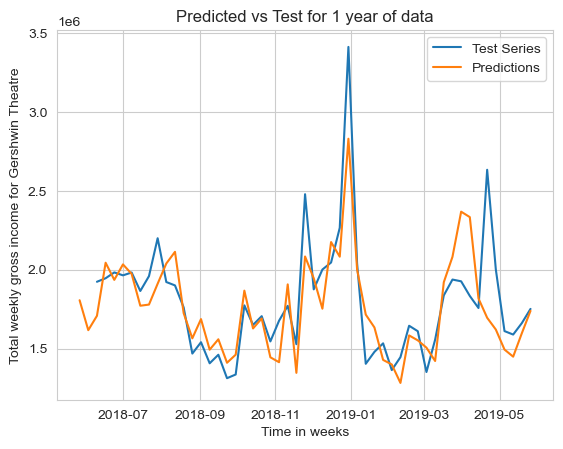

In [22]:
#Using the best lag and doing prediction


model = AutoReg(train, lags=62) # Fit the AutoReg model with a lag of 1
results = model.fit()

print(results.summary())

preds = results.predict(start=259, end=311) # Predict the next 5 values
print(preds)

#plt.plot(train.index,train, label='Original Series')
plt.plot(test.index,test, label='Test Series')
plt.plot(preds, label='Predictions')
plt.title("Predicted vs Test for 1 year of data")
plt.xlabel("Time in weeks")
plt.ylabel("Total weekly gross income for Gershwin Theatre")
plt.legend()
plt.show()